In [1]:
import glob
import scipy.stats
import numpy as np
import pickle
import os

from itertools import combinations
from scipy import spatial
from metrics import rsa
from data import one_hot
from tqdm import tqdm_notebook

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

baseline_path = 'runs/lstm_h_64_lr_0.001_max_len_10_vocab_25'

In [2]:
def get_run_name(run:str)->str:
    if run == 'lstm_h_64_lr_0.001_max_len_10_vocab_25':
        return 'baseline'
    else:
        return run
    
# Loading metrics from saved pickles
metrics = {}
for m in glob.glob("runs/*/*/*.pkl"):
    run = m.split('/')[1]
    run_name = get_run_name(run)
    if run_name not in metrics:
        metrics[run_name] = {}
    seed = m.split('/')[2]
    if seed not in metrics[run_name]:
        metrics[run_name][seed]={}
        
    iteration = int(m.split('_')[-1].split('.')[0])
    metrics[run_name][seed][iteration] = pickle.load(open(m, 'rb'))

In [3]:
metrics['baseline']['1'][0].keys()

dict_keys(['loss', 'acc', 'entropy', 'messages', 'h_sender', 'h_rnn_sender', 'h_receiver', 'h_rnn_receiver', 'targets', 'distractors', 'RSA:h_sender/h_rnn_sender', 'RSA:h_sender/h_receiver', 'RSA:h_sender/h_rnn_receiver', 'RSA:h_sender/targets', 'RSA:h_sender/messages', 'RSA:h_rnn_sender/h_receiver', 'RSA:h_rnn_sender/h_rnn_receiver', 'RSA:h_rnn_sender/targets', 'RSA:h_rnn_sender/messages', 'RSA:h_receiver/h_rnn_receiver', 'RSA:h_receiver/targets', 'RSA:h_receiver/messages', 'RSA:h_rnn_receiver/targets', 'RSA:h_rnn_receiver/messages', 'RSA:targets/messages'])

In [4]:
print(metrics.keys())

dict_keys(['baseline', 'lstm_h_64_lr_0.001_max_len_10_vocab_25_same_data_attr_5', 'lstm_h_64_lr_0.001_max_len_10_vocab_25_attr_1', 'lstm_h_64_lr_0.001_max_len_10_vocab_25_attr_2'])


In [5]:
def plot_metric(results, metric="loss", ylabel=None, show_error=True, 
                savefig=True, figname=None, title=None, ylim=None, a4_dims=(11.7, 8.27)):
    
    ci = 'sd' if show_error else None
    fig, ax = plt.subplots(figsize=a4_dims)
    
    generations = []
    values = []
    run_names = []
    
    for r in list(results.keys()):
        # LET OP, HIER CHECKEN WE OP HET MOMENT ALLEEN DE BASELINE
        if r == 'baseline':
            for s in list(results[r].keys()):    
                for g in sorted(list(results[r][s].keys())):
                    generations.append(g)
                    values.append(results[r][s][g][metric])
                    run_names.append(r)
            
    values = np.array(values)
    iterations = np.array(generations)   
      
    d = {'Iterations': iterations,'': run_names, metric: values}
    ax = sns.lineplot(ax=ax, x='Iterations', y=metric, data=pd.DataFrame(data=d))

    if title is None:
        title = metric.replace('_', ' ').title()
    ax.set_title(title, fontsize=30)
    plt.show()


/home/oscar/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


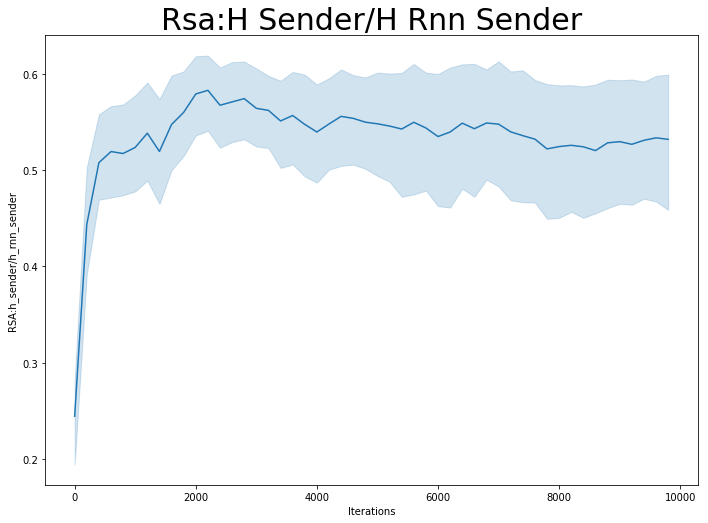

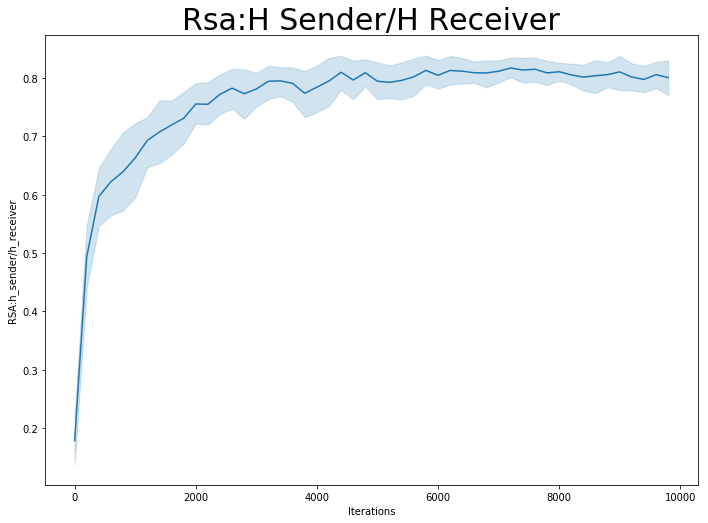

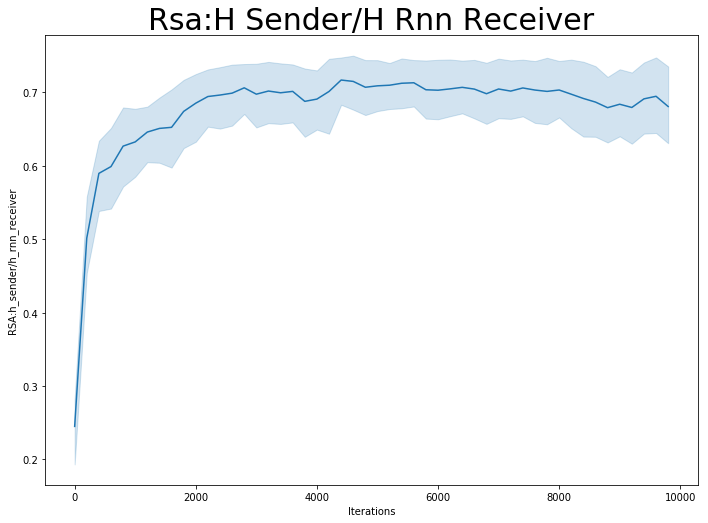

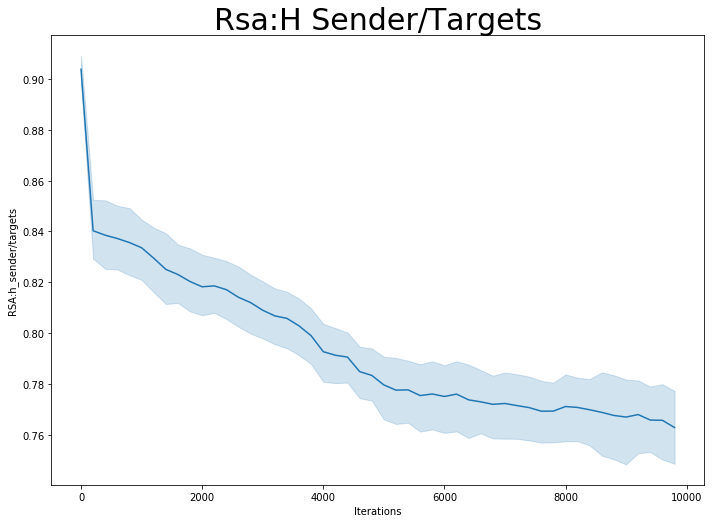

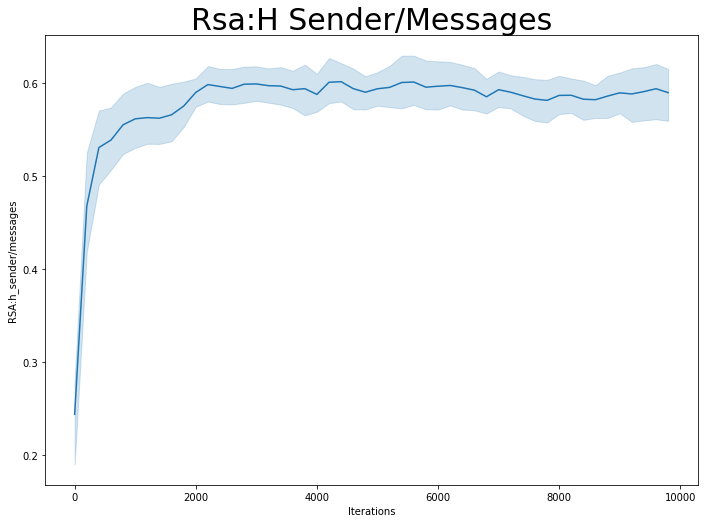

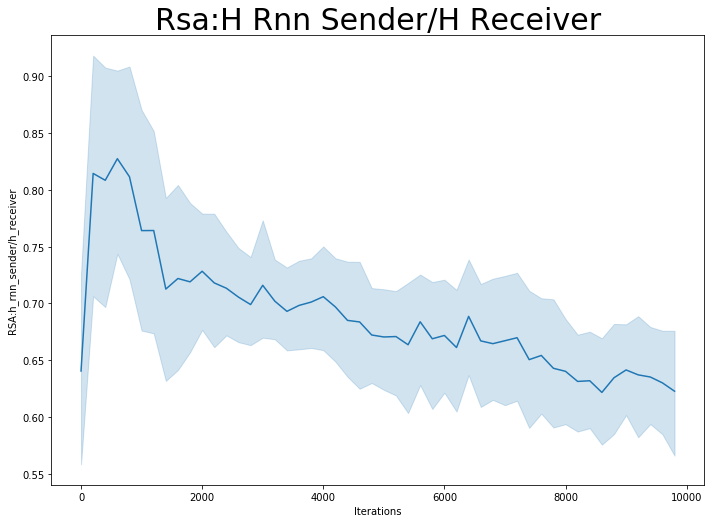

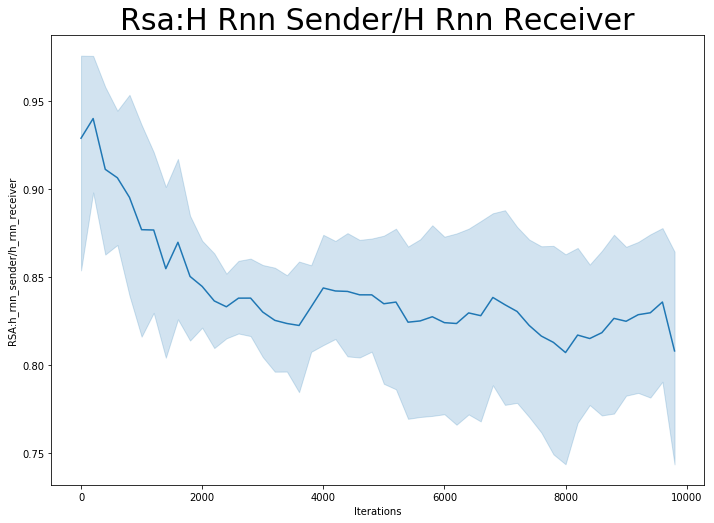

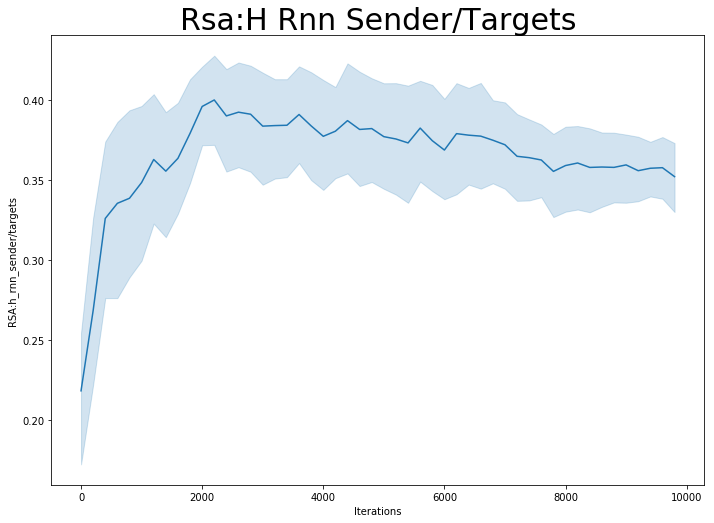

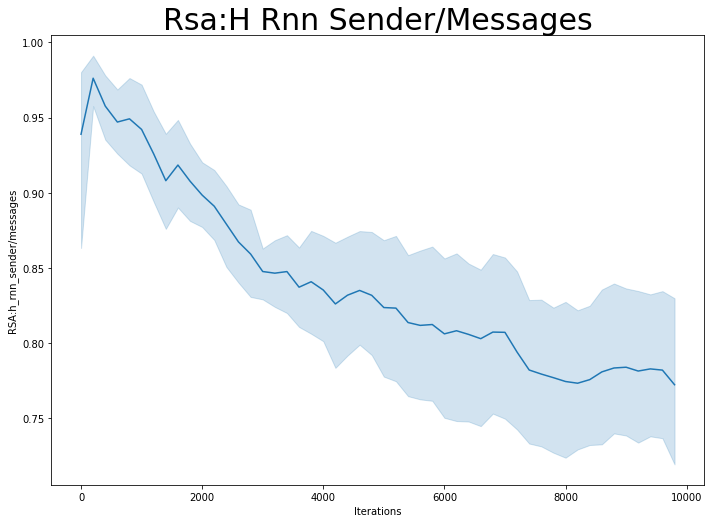

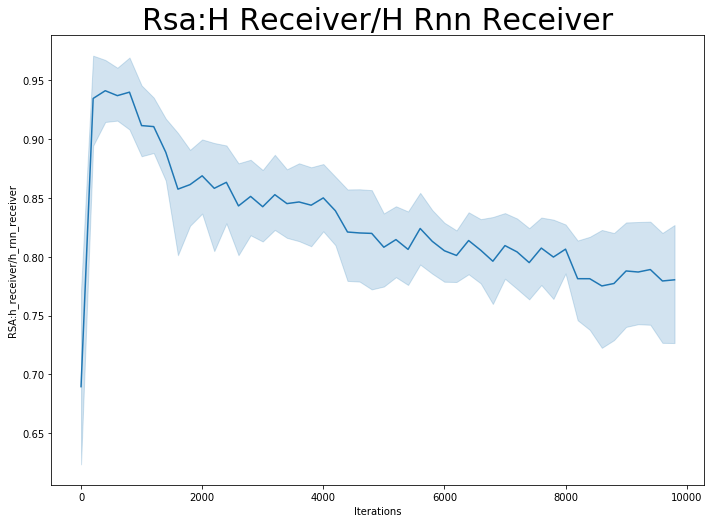

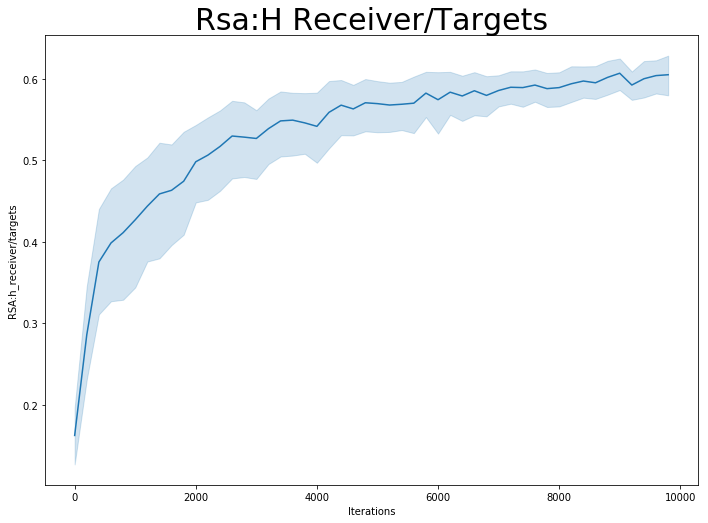

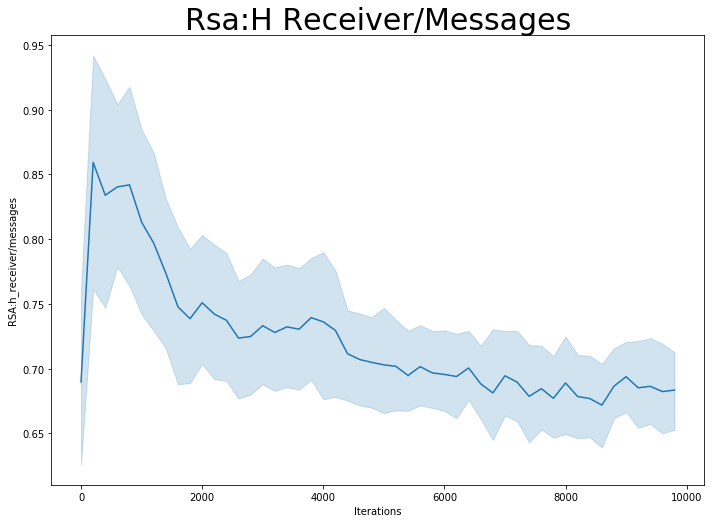

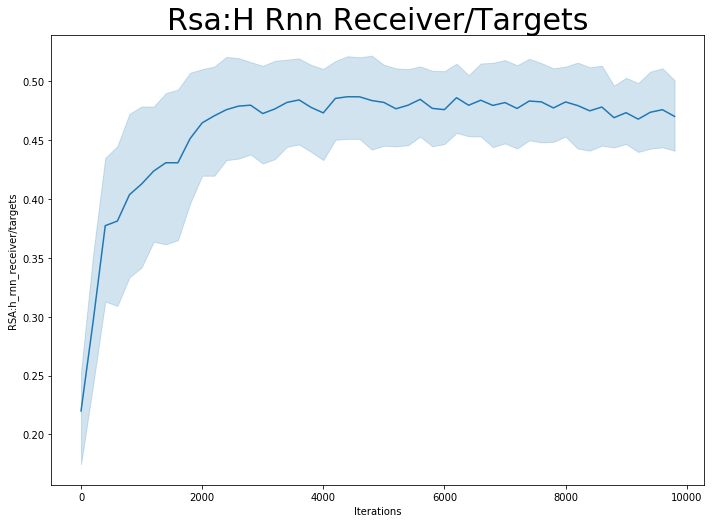

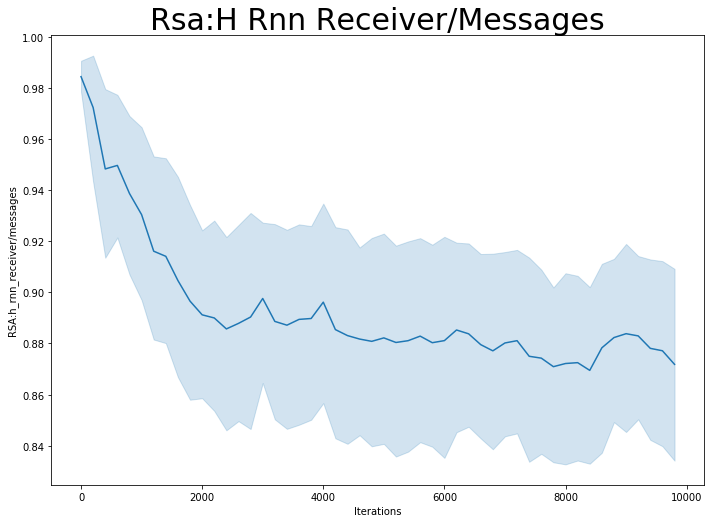

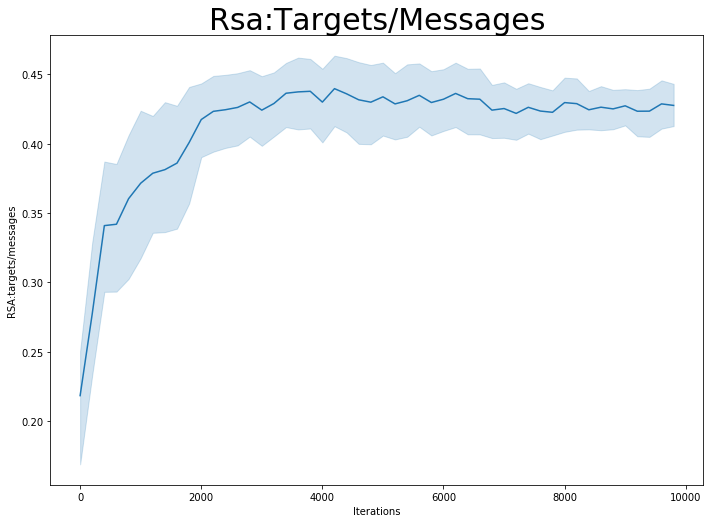

In [7]:
for k in metrics['baseline']['1'][0]:
    if 'RSA' in k:
        plot_metric(metrics, metric=k)

# Standard Indicators

/home/oscar/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


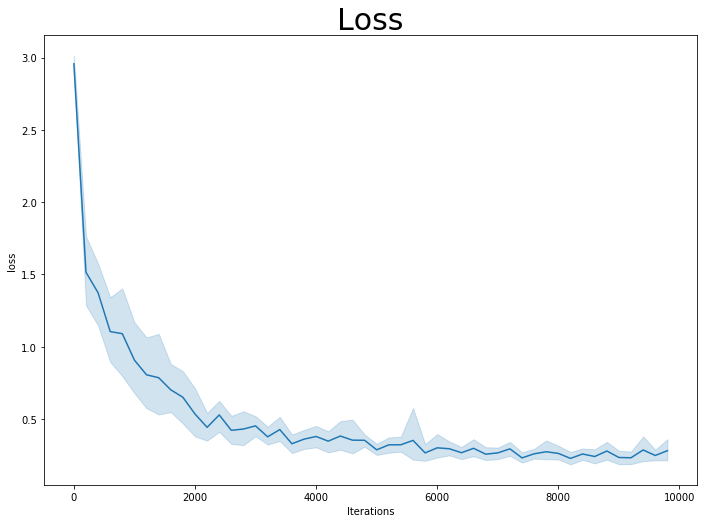

In [8]:
plot_metric(metrics)

/home/oscar/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


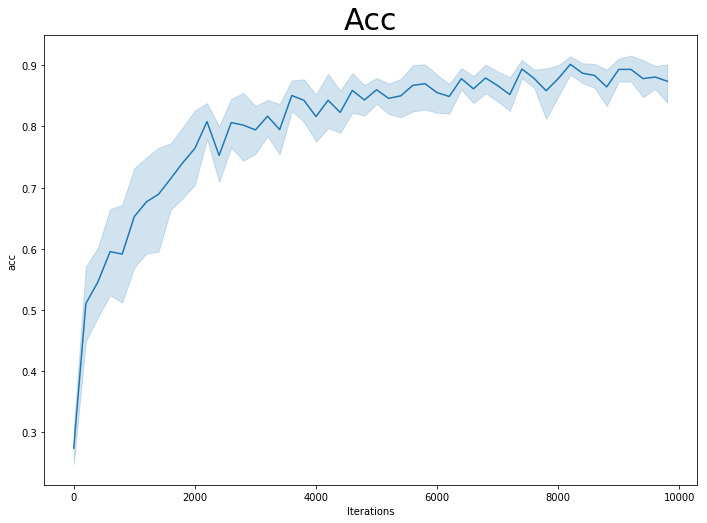

In [9]:
plot_metric(metrics, metric="acc")

/home/oscar/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


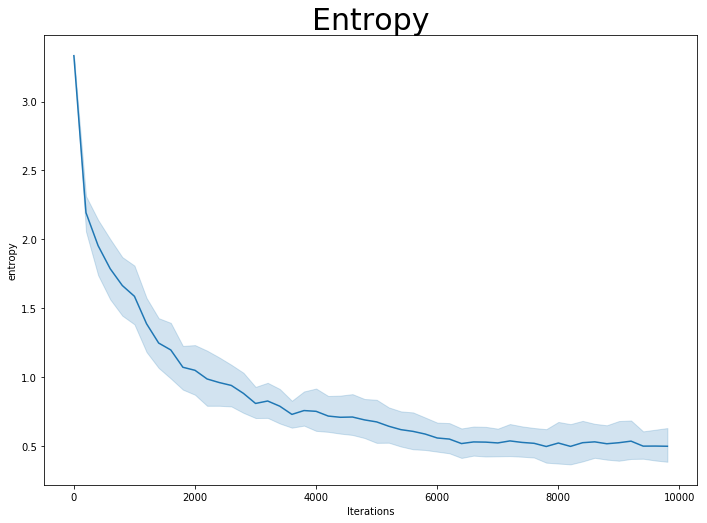

In [10]:
plot_metric(metrics, metric="entropy")

# Standard RSA Metrics 

Variables:
- H_Sender: The hidden state after passing input through linear layer (this hidden state initializes the RNN)
- H_RNN_Sender: The hidden states output that generated each word in the message
- H_RNN_receiver: The hidden states output after passing over each word in message
- H_Receiver: The hidden state outputed by the final output layer (this is used to calculate Score w.r.t. original input)
- Targets: Target/Input vectors for instance (1 0 0 1 0 0 1 0 1 0 0 1 0 0) 
- Messages: Discrete Messages generated by sender

Distances used:
- "h_sender": spatial.distance.cosine
- "h_rnn_sender": flatten_cos #flatten sequence and run cosine distance
- "h_receiver": spatial.distance.cosine
- "h_rnn_receiver": flatten_cos #flatten sequence and run cosine distance
- "targets": spatial.distance.hamming 
- "messages": on_hot_hamming #one hot sequence, flatten and then run hamming distance


/home/oscar/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


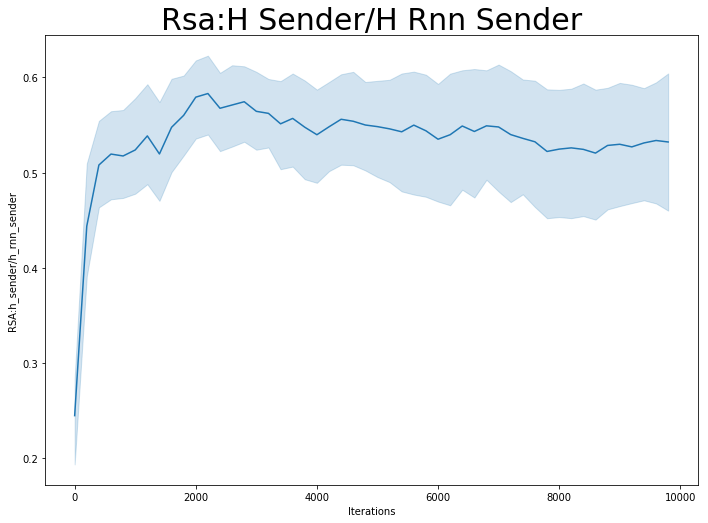

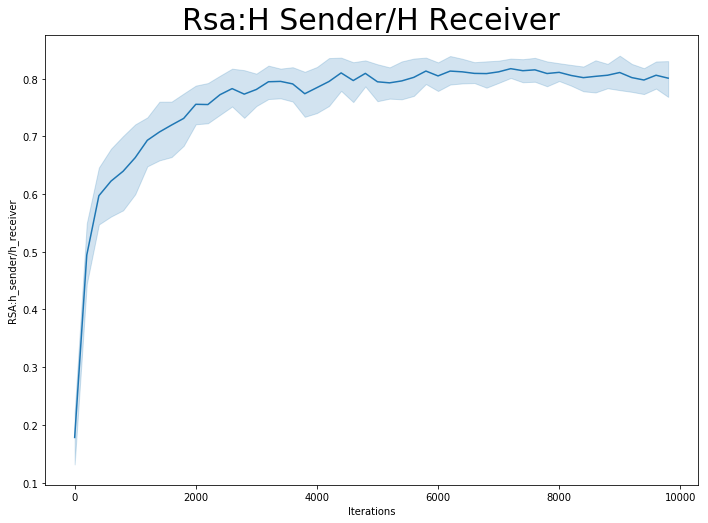

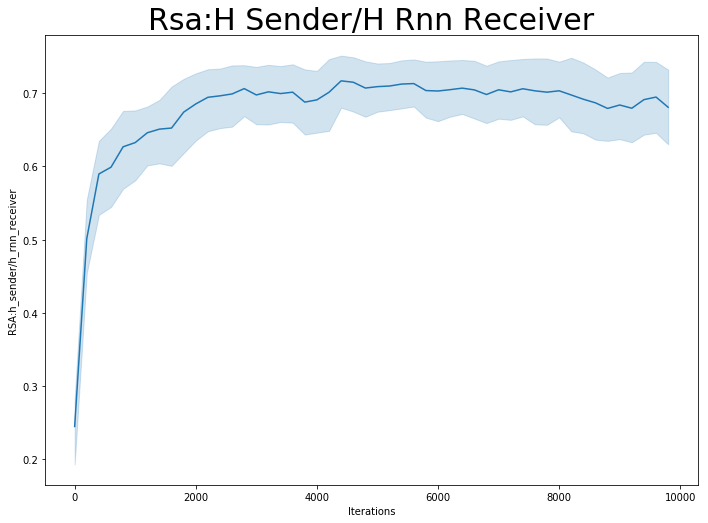

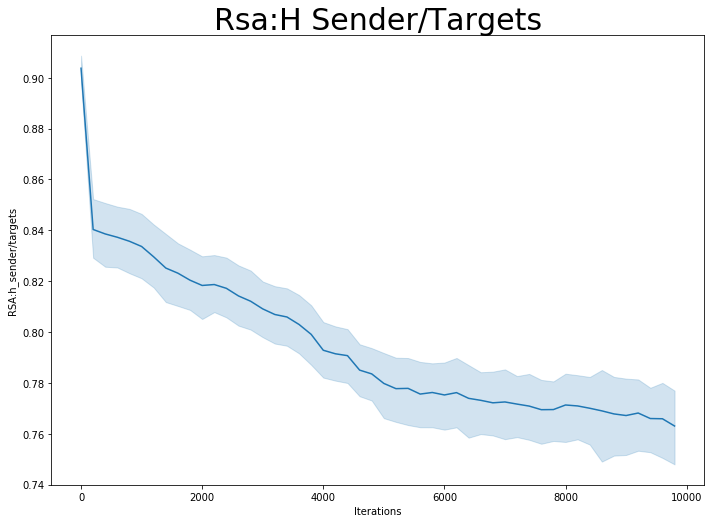

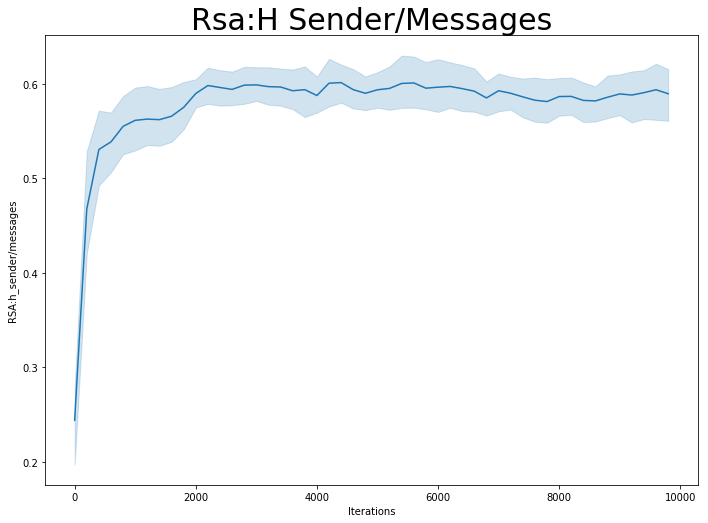

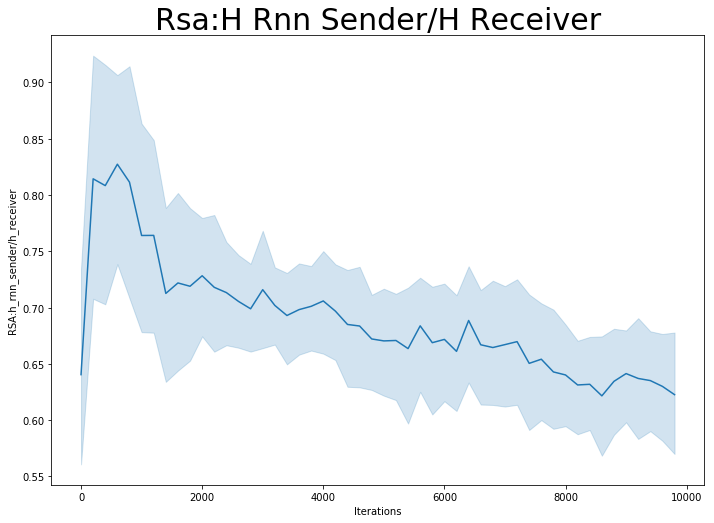

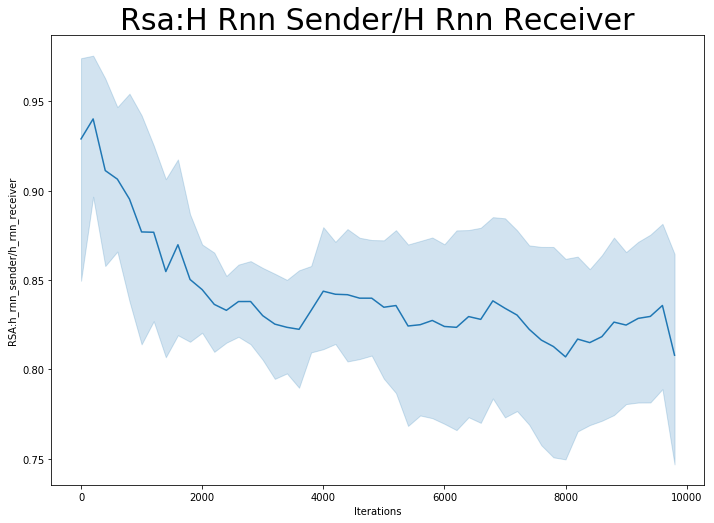

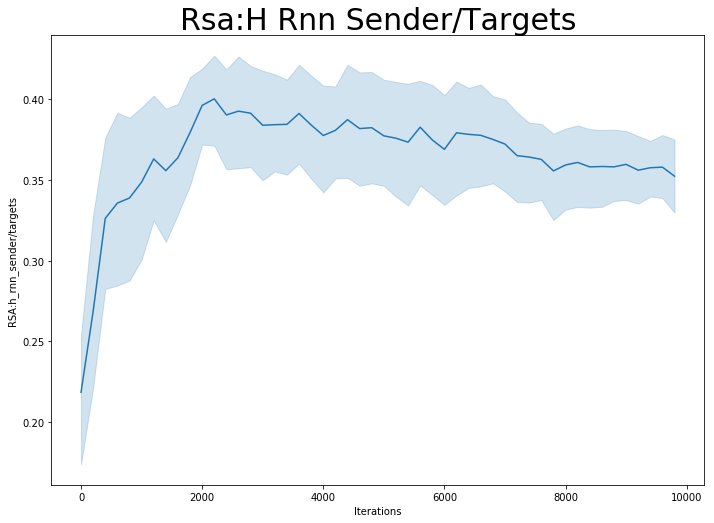

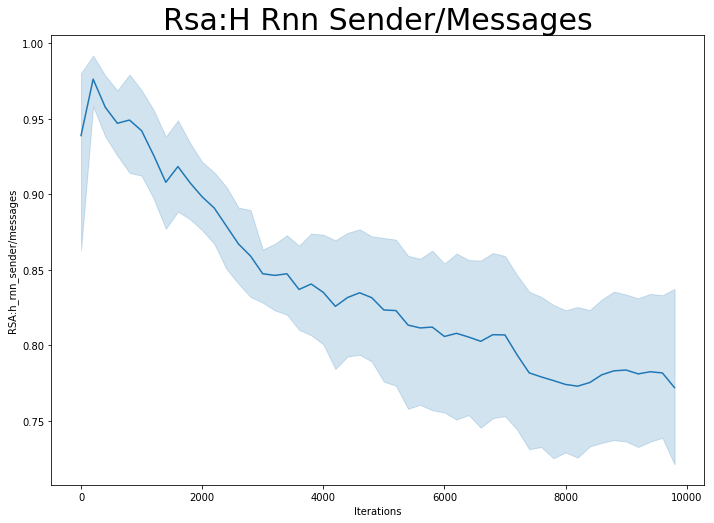

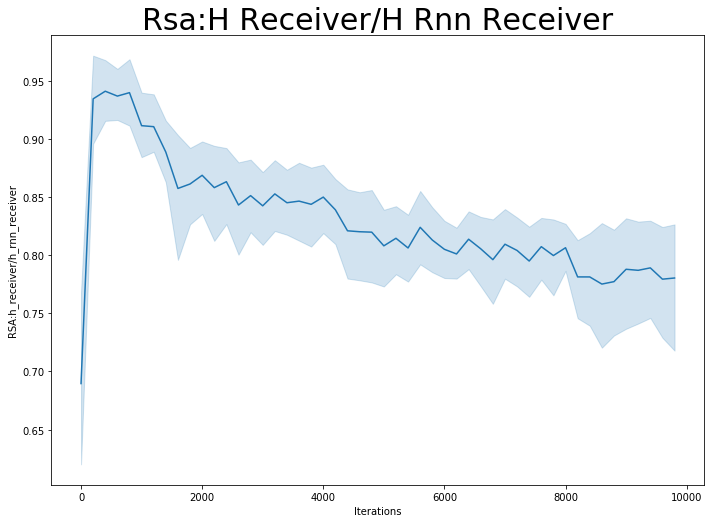

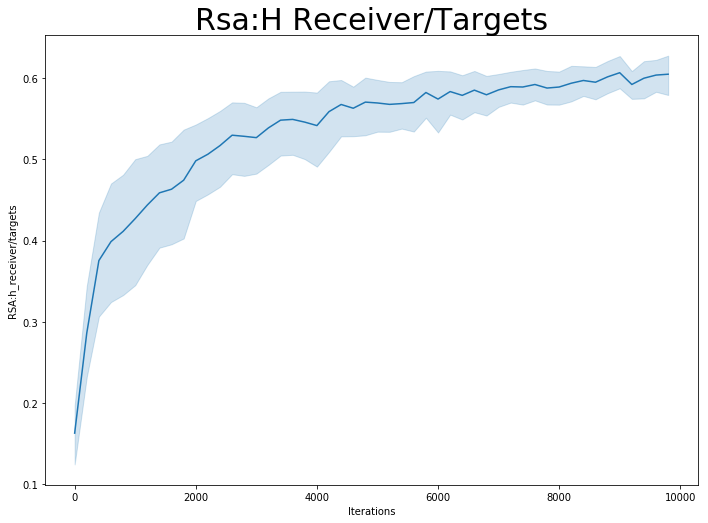

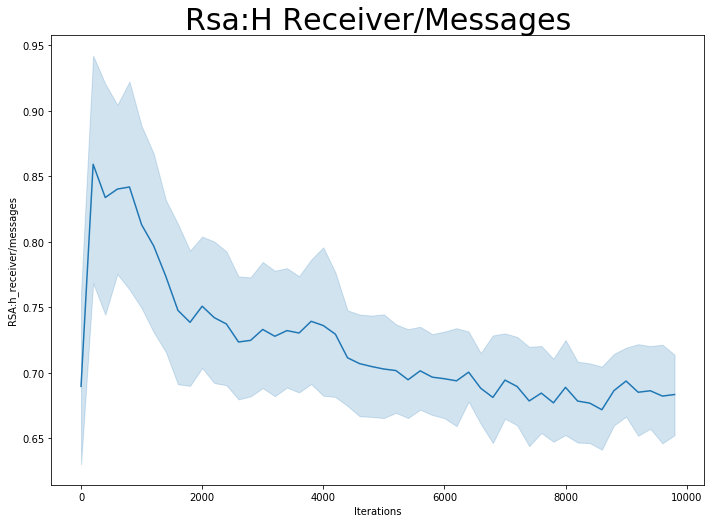

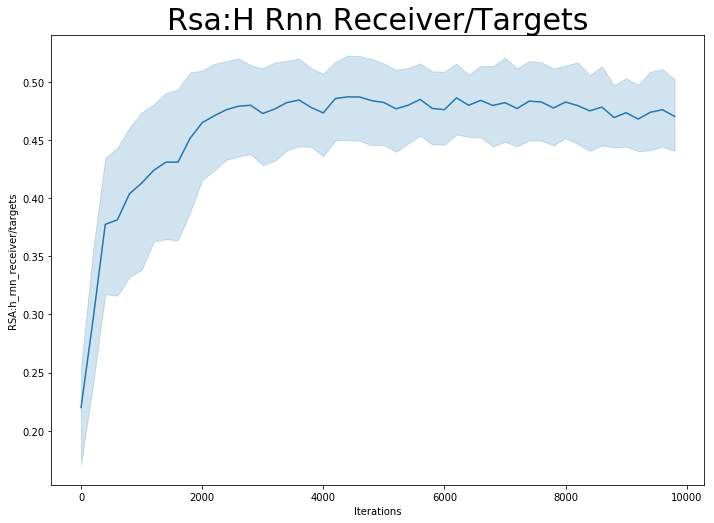

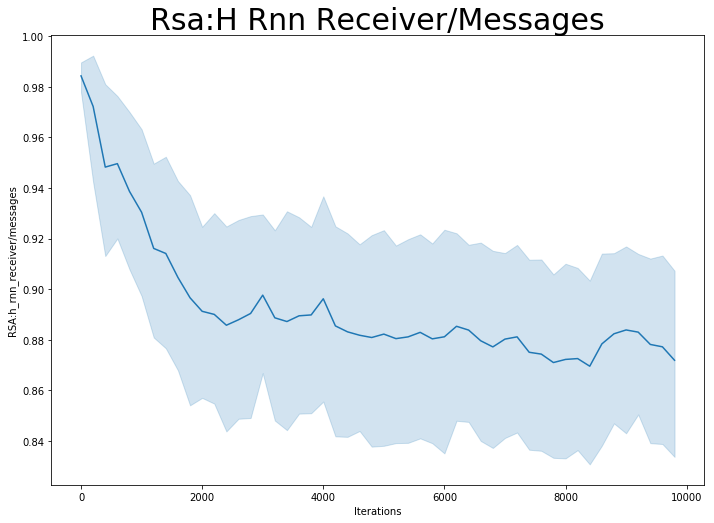

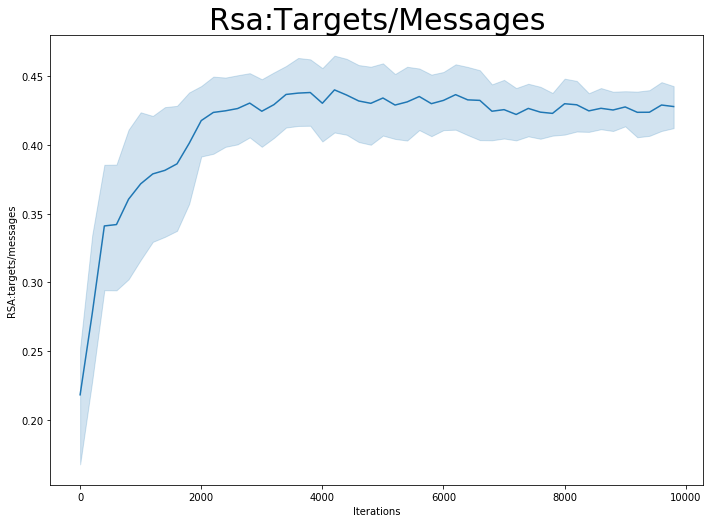

In [11]:
for k in metrics['baseline']['1'][0]:
    if 'RSA' in k:
        plot_metric(metrics, metric=k)

# Cross Seed RSA

In [12]:

def plot_rsa_metric(results, metric, ylabel=None, show_error=True, 
                    savefig=True, figname=None, title=None, ylim=None, a4_dims=(11.7, 8.27)):
    
    # initialize plots
    ci = 'sd' if show_error else None
    fig, ax = plt.subplots(figsize=a4_dims)
    
    # get data to fill up plot
    all_values = []
    for result in results.values():
        
        generations = []
        values = []
        run_names = []

        for s in list(result[metric].keys()):    
            for g in sorted(list(result[metric][s].keys())):
                generations.append(g)
                values.append(result[metric][s][g])
                run_names.append(metric)

        values = np.array(values)
        iterations = np.array(generations)   
        all_values.append(values)
    
    # initialize data dictionary
    d = {'Iterations': iterations}
    
    # fill dictionary with rest of data
    for i, key in enumerate(results.keys()):
        d[key] = all_values[i]    
    data_preproc=pd.DataFrame(data=d)
    #print(pd.melt(data_preproc, ['Iterations']))

    ax = sns.lineplot(x='Iterations', y="RSA", hue='method', 
                      data=pd.melt(data_preproc, ['Iterations'],
                                   var_name='method',
                                   value_name="RSA"))

    if title is None:
        title = metric.replace('_', ' ').title()
    ax.set_title(title, fontsize=30)
    plt.show()

/home/oscar/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


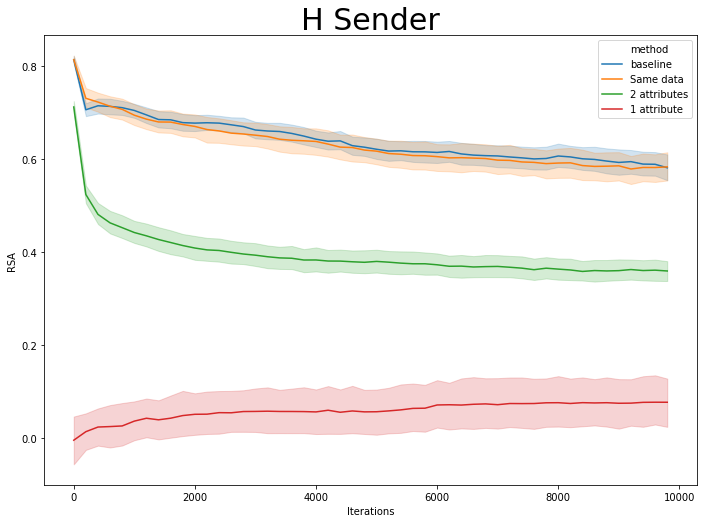

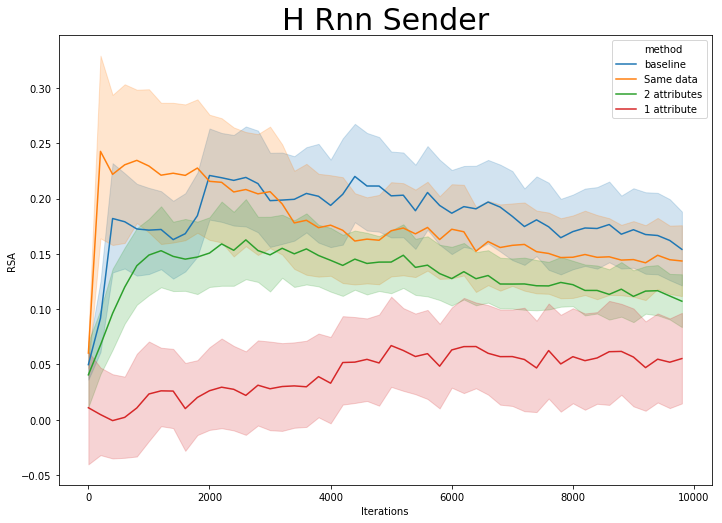

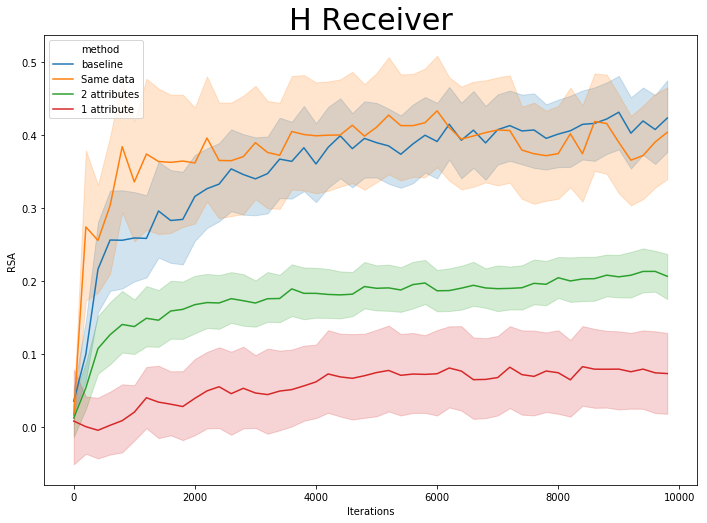

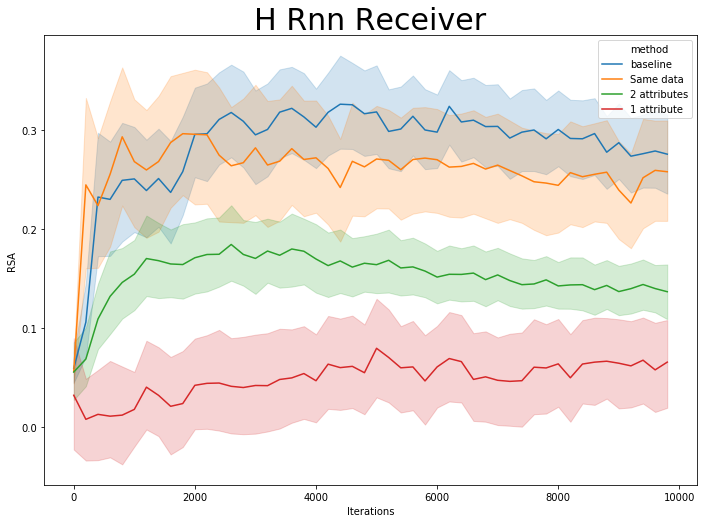

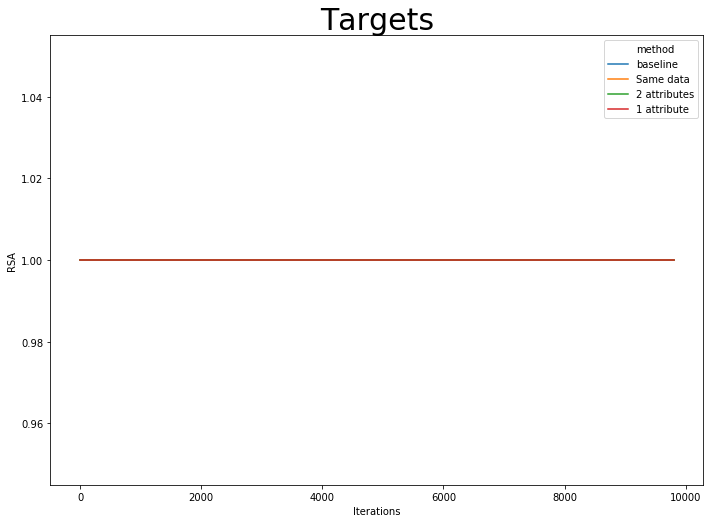

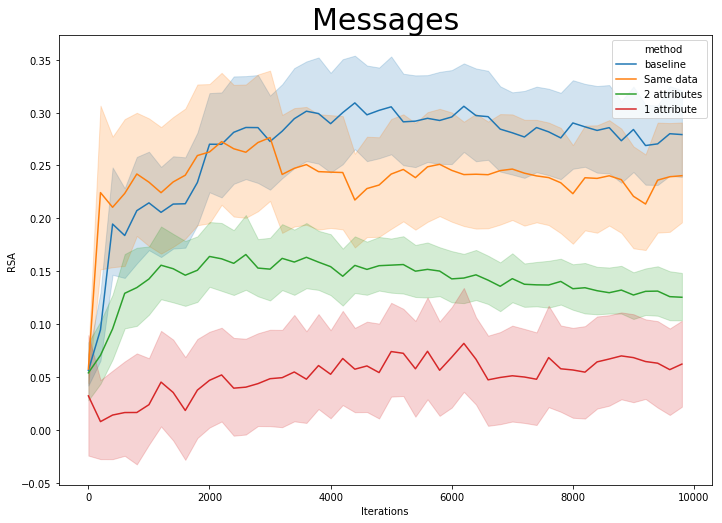

In [13]:
RSA_BASELINE = pickle.load(open(f'{baseline_path}/rsa_analysis.pkl', 'rb'))
RSA_SAME_DATA = pickle.load(open(f'runs/lstm_h_64_lr_0.001_max_len_10_vocab_25_same_data_attr_5/rsa_analysis.pkl', 'rb'))
RSA_2_ATTR = pickle.load(open(f'runs/lstm_h_64_lr_0.001_max_len_10_vocab_25_attr_2/rsa_analysis.pkl', 'rb'))
RSA_1_ATTR = pickle.load(open(f'runs/lstm_h_64_lr_0.001_max_len_10_vocab_25_attr_1/rsa_analysis.pkl', 'rb'))
 

RSA_ANALYSIS = {'baseline': RSA_BASELINE,
                'Same data': RSA_SAME_DATA,
                '2 attributes': RSA_2_ATTR,
                '1 attribute': RSA_1_ATTR
               }

for k in RSA_BASELINE:
    plot_rsa_metric(RSA_ANALYSIS, metric=k)